In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import string 
import itertools
from collections import Counter
import os
import re
from os import path
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import plotly.express as px
import time
import asyncio
import click
from ipywidgets import widgets

In [2]:
corpus = pd.read_csv('data/raw/guardian_environment.csv')

col_of_interest = ['id', 'webPublicationDate', 'fields_publication', 'fields_byline',
                   'fields_headline', 'fields_standfirst', 'fields_body', 'fields_bodyText',
                   'fields_wordcount', 'fields_charCount']
# select columns of interest
corpus = corpus.loc[:, col_of_interest]
# convert 'webPublicationDate' field to year
corpus['webPublicationDate'] = pd.to_datetime(corpus['webPublicationDate']).dt.year
# rename columns
new_colnames = {'webPublicationDate': 'year', 'fields_publication': 'where', 'fields_byline': 'author',
                'fields_headline': 'headline', 'fields_standfirst': 'standfirst', 'fields_body': 'body', 'fields_bodyText':'bodyText',
                'fields_wordcount': 'wordcount', 'fields_charCount': 'charcount'}
corpus.rename(columns=new_colnames, inplace=True)

corpus = corpus[corpus['bodyText'].isna() == False]

corpus['headline'][corpus['headline'].isna() == True] = ''
corpus['standfirst'][corpus['standfirst'].isna() == True] = ''

with open('data/guardian_environment/info.json', 'r') as f:
    info = json.load(f)
    vocab = info['vocab_tr']
    corpus = corpus.iloc[info['indices_tr'], :]
    docs_bow = [[vocab[v] for v in doc] for doc in info['docs_tr']]
    del info

In [3]:
#fig, ax = plt.subplots(figsize = (10,6))
#plt.rcParams['font.size'] = '14'
#for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontsize(14)
    
#sns.set(style = "darkgrid")
#sns.histplot(data = corpus, x = "year", bins = 10).set
#plt.xlabel('Date', fontsize = 16)
#plt.ylabel('Count', fontsize = 16)
#plt.title('Histogram by pubblication date', fontsize = 16)
#plt.show()

fig = px.bar(corpus.groupby(['year'])['year'].count().reset_index(name='Count'), x = 'year', y = 'Count',
             title="Histogram by pubblication date", labels = dict(year = 'Year'))
fig.update_traces(marker_line_width = 1, marker_line_color = 'black')
fig.show()

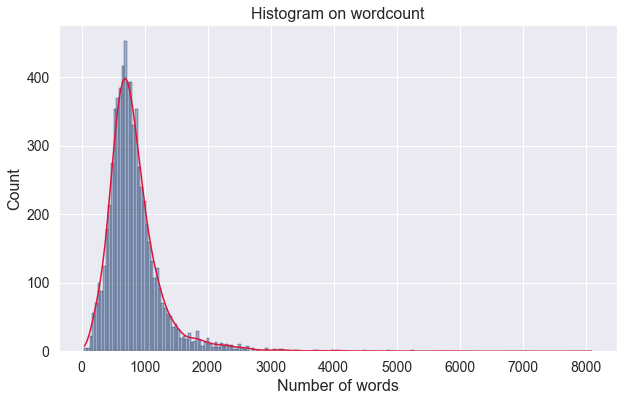

In [24]:
fig, ax = plt.subplots(figsize = (10,6))
plt.rcParams['font.size'] = '14'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
    
sns.set(style = 'darkgrid')
sns.histplot(data = corpus, x = "wordcount", kde = True, edgecolor = 'black')
ax.lines[0].set_color('crimson')
plt.xlabel('Number of words', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title('Histogram on wordcount', fontsize = 16)
plt.show()

Documents with more than 3000 words is 51


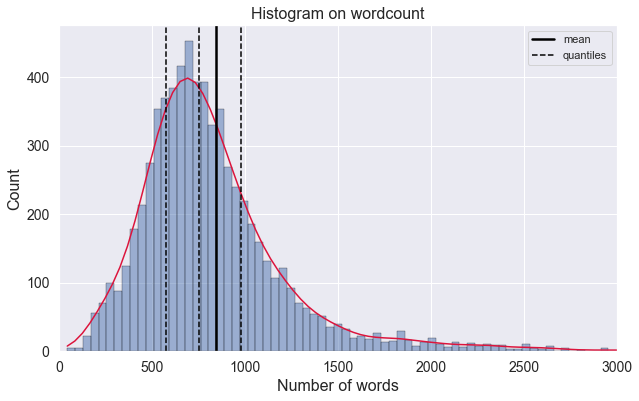

In [5]:
l = ['mean', '1st quartiles','median','3rd quartile','histogram']

fig, ax = plt.subplots(figsize = (10,6))
plt.rcParams['font.size'] = '14'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
    
print('Documents with more than 3000 words is '+str(len(corpus[corpus['wordcount'] >= 3000])))
sns.set(style = 'darkgrid')
sns.histplot(data = corpus, x = 'wordcount', kde = True, edgecolor = 'black')
ax.lines[0].set_color('crimson')
plt.xlabel('Number of words', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title('Histogram on wordcount', fontsize = 16)
plt.xlim(0,3000)
m = plt.axvline(np.mean(corpus['wordcount']), linewidth = 2.5, color = 'black', label = 'mean')
q_1 = plt.axvline(np.percentile(corpus['wordcount'], 25), linestyle = '--', color='black', label = 'quantiles')
q_2 = plt.axvline(np.percentile(corpus['wordcount'], 50), linestyle = '--', color='black')
q_3 = plt.axvline(np.percentile(corpus['wordcount'], 75), linestyle = '--', color='black')
plt.legend(handles=[m, q_1])
plt.show()

In [6]:
#fig, ax = plt.subplots(figsize = (10,6))
#plt.rcParams['font.size'] = '14'
#for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontsize(14)
    
#sns.set(style='darkgrid')
#sns.histplot(data=corpus, x='where')
#plt.xlabel('Magazine', fontsize = 16)
#plt.ylabel('Count', fontsize = 16)
#plt.title('Histogram on sub-journals', fontsize = 16)
#plt.show()

In [7]:
fig = px.pie(corpus.groupby(['where'])['where'].count().reset_index(name = 'count'), values = 'count', names = 'where',
             title ='Pie chart on sub-journals',
             hole = 0.35)
fig.update_traces(textposition = 'outside',
                                  textinfo = 'percent+label',
                                  marker = dict(line = dict(color = '#000000',
                                                        width = 4)),
                                  pull = [0.05, 0, 0.03],
                                  opacity = 0.9,
                                  # rotation=180
                                  )
fig.show()

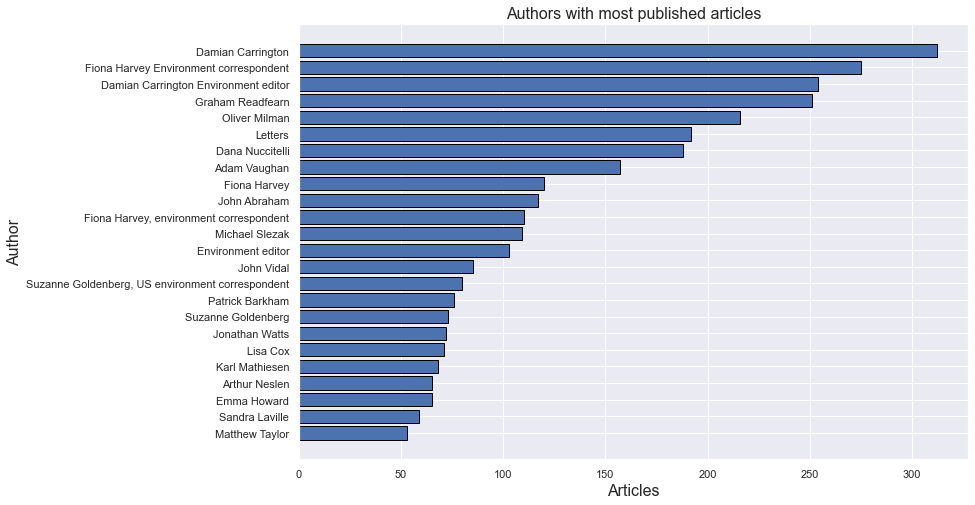

In [19]:
absolute_frequencies = dict()
for author in corpus['author']:
    if author in absolute_frequencies.keys():
        absolute_frequencies[author] += 1
    else:
        absolute_frequencies[author] = 1

absolute_frequencies_2 = {}
for key, value in absolute_frequencies.items():
    if value >= 50:
        absolute_frequencies_2[key] = value
        
absolute_frequencies_2.pop(np.nan, None) # 91 articles have unkown authors.  
    
absolute_frequencies_2

ind = np.arange(len(absolute_frequencies_2))
palette = sns.color_palette('husl', len(absolute_frequencies_2))
absolute_frequencies_3 = dict(sorted(absolute_frequencies_2.items(), key = lambda item: item[1]))

plt.figure(figsize = (12,8))
plt.rcParams['font.size'] = '12'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)

plt.barh(ind, list(absolute_frequencies_3.values()), align = 'center', edgecolor = 'black')
plt.yticks(ind, list(absolute_frequencies_3.keys()))
plt.ylabel('Author', fontsize = 16)
plt.xlabel('Articles', fontsize = 16)
plt.title('Authors with most published articles', fontsize = 16)
plt.show()

In [9]:
docs_bowf = [item for sublist in docs_bow for item in sublist]
docs_bowf_count = Counter(docs_bowf)

tot_dwords = {}
tot_dword = dict(sorted(docs_bowf_count.items(), key = lambda item: item[1]))

#tot_dword

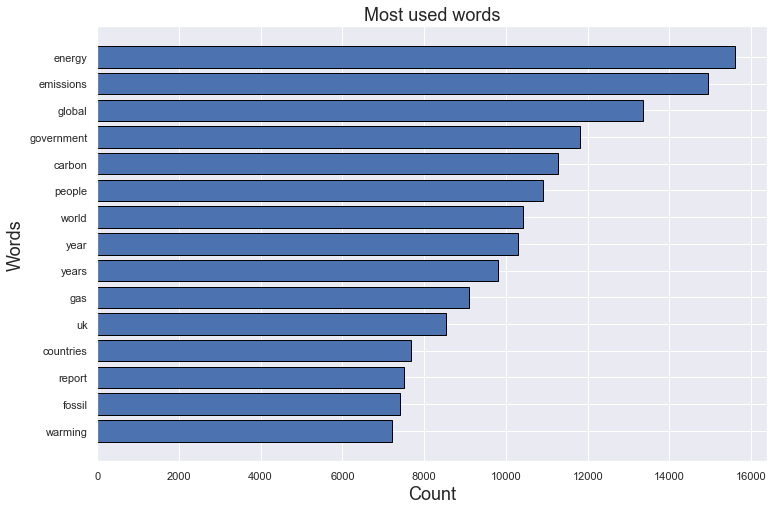

In [18]:
num_best_words = 15
best_tot_dwords = dict(sorted(tot_dword.items(), key = lambda item: item[1], reverse = True)[:num_best_words])

ind = np.arange(len(best_tot_dwords))
palette = sns.color_palette('husl', len(best_tot_dwords))
best_tot_dwords_2 = dict(sorted(best_tot_dwords.items(), key=lambda item: item[1]))

plt.figure(figsize = (12,8))
plt.rcParams['font.size'] = '14'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
    
plt.barh(ind, list(best_tot_dwords_2.values()), align = 'center', edgecolor = 'black')
plt.yticks(ind, list(best_tot_dwords_2.keys()))
plt.ylabel('Words', fontsize = 18)
plt.xlabel('Count', fontsize = 18)
plt.title('Most used words', fontsize = 18)
plt.show()

In [11]:
#wordcloud = WordCloud().generate_from_frequencies(tot_dword)

#plt.subplots(figsize = (18,8))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")
#plt.show()

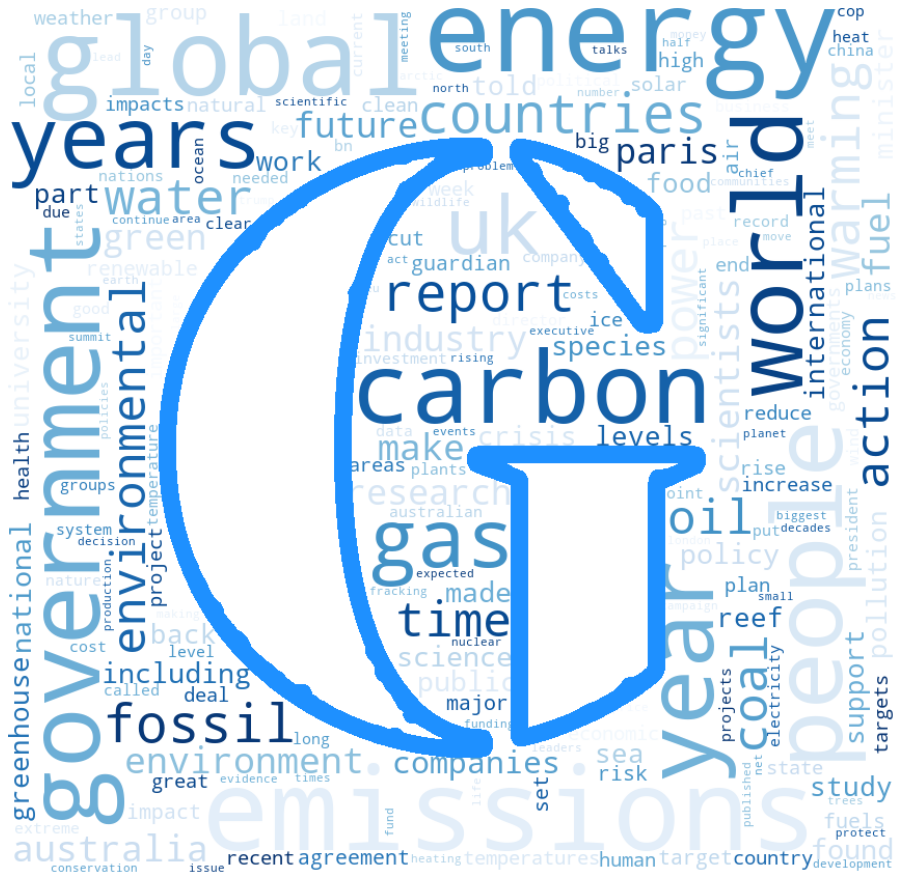

In [23]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if '__file__' in locals() else os.getcwd()

guardian_mask = np.array(Image.open(path.join(d, 'guardian.png')))

wc = WordCloud(background_color = 'white',
               mask = guardian_mask,
               contour_width = 30,
               colormap = 'Blues',
               contour_color = 'dodgerblue').generate_from_frequencies(tot_dword)

plt.figure(figsize = (16,16))
plt.imshow(wc, interpolation = 'bilinear', aspect = 'auto')
plt.axis('off')
plt.show()

In [13]:
timestamps = [str(y) for y in corpus['year']]
timestamps
len(timestamps)

docs_by_year = {}
year_list = sorted(list(set(timestamps)))
for year in year_list:
    docs_by_year[year] = [docs_bow[d] for d in range(len(docs_bow)) if timestamps[d] == year]

In [21]:
@widgets.interact(Year = year_list)
def get_wordcloud(Year):
    docs_bowf_year = [item for sublist in docs_by_year[str(year)] for item in sublist]
    docs_bowf_count_year = Counter(docs_bowf_year)

    tot_dwords_year = {}
    tot_dword_year = dict(sorted(docs_bowf_count_year.items(), key = lambda item: item[1]))

    wordcloud = WordCloud(background_color = 'white', colormap = 'Blues').generate_from_frequencies(tot_dword_year)

    plt.figure(figsize = (20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

interactive(children=(Dropdown(description='Year', options=('2013', '2014', '2015', '2016', '2017', '2018', '2…

In [15]:
# create data

topic = [10,20,30,40,50]

m = np.array([[1, 4, 5, 12,13], 
    [-5, 8, 9, 0, 11],
    [-6, 7, 11, 19, 4],
    [7, 3, 8, 14, 8],
    [-1, 2, 20, 10, 3]])

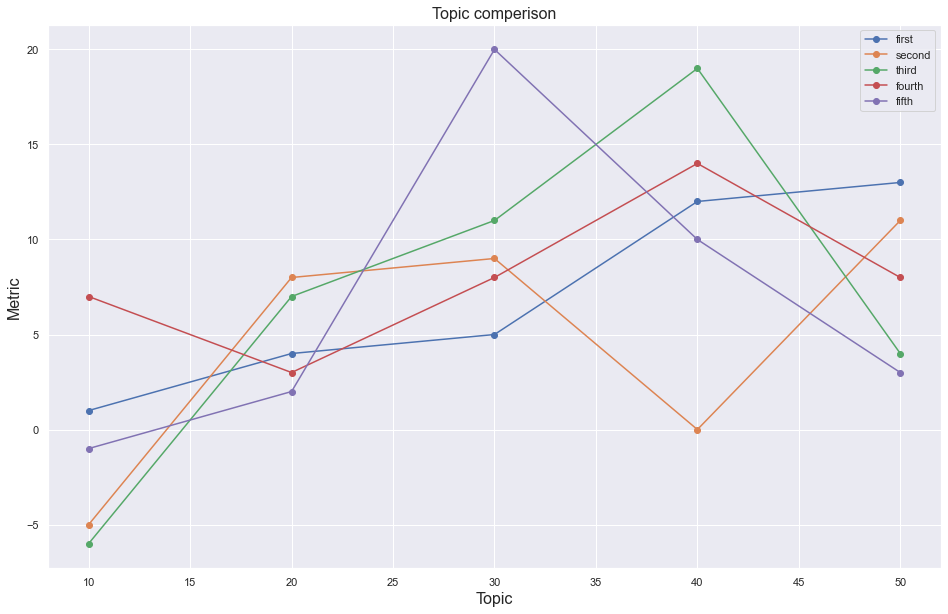

In [16]:
# plot lines
plt.figure(figsize = (16,10))
plt.rcParams['font.size'] = '12'
plt.plot(topic, m[0], label = "first", marker = 'o')
plt.plot(topic, m[1], label = "second", marker = 'o')
plt.plot(topic, m[2], label = "third", marker = 'o')
plt.plot(topic, m[3], label = "fourth", marker = 'o')
plt.plot(topic, m[4], label = "fifth", marker = 'o')
plt.xlabel('Topic', fontsize = 16)
plt.ylabel('Metric', fontsize = 16)
plt.title('Topic comperison', fontsize = 16)

plt.legend()
plt.show()